In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, itertools

In [58]:
class Fitness:
    def __init__(self, cameraPositions, roomMap, R, N):
        self.cameraPositions = cameraPositions
        self.numberOfCameras = len(cameraPositions)
        self.map = roomMap
        self.radius = R
        self.minNumberOfCameras = N
        self.coverage = 0.0
        self.fitness = 0.0
    
    def roomCoverage(self):
        if self.coverage == 0:
            countCoveredPixels = 0
            roomInteriorCount = np.count_nonzero(self.map >= 1)
            cameraCoverageMap = self.map * 0;
            cameraRadius = (self.radius*2)+1
            # go through each camera
            #print ("Map:\n", self.map)
            #print ("Camera Positions: \n", self.cameraPositions)
            for cameraPosition in self.cameraPositions:
                # add 1 to pixel and pixels within radius, if it is room interior.
                
                subMatrixRowStart = max(0, cameraPosition[0]-self.radius)
                subMatrixRowEnd = min(len(self.map), cameraPosition[0]+self.radius) + 1
                subMatrixColStart = max(0, cameraPosition[1]-self.radius)
                subMatrixColEnd = min(len(self.map[0]), cameraPosition[1]+self.radius) + 1
               
                cameraCoverageMap[subMatrixRowStart:subMatrixRowEnd, 
                                  subMatrixColStart:subMatrixColEnd] += 1
                
    
            #countCoveredPixels = count how many pixels have count N
            cameraCoverageMap = cameraCoverageMap * self.map
#             print ("Camera Coverege Map 2: \n", cameraCoverageMap)
            countCoveredPixels = np.count_nonzero(cameraCoverageMap >= self.minNumberOfCameras)
            
            self.coverage = countCoveredPixels / roomInteriorCount
        return self.coverage
    
    def cameraFitness(self):
        if self.fitness == 0:
            self.fitness = self.roomCoverage(), self.numberOfCameras
        return self.fitness

In [3]:
def createCameraCombination(cameraList):
    # camNumber = choose randomly how many cameras to place (< room interior pixel count)
    # count room interior pixels and get a list of locations
    roomInteriorPixels = 0
    camNumber = 0
    camLocations = [] # [[1,1], [1, 2], ...]
    
    for rowCount in range(0, len(cameraList)):
        for columnCount in range(0, len(cameraList[rowCount])):
            if (cameraList[rowCount][columnCount] == 1):
                roomInteriorPixels += 1
                camLocations.append([rowCount, columnCount])
    
    camNumber = random.randint(1, roomInteriorPixels)
    
    # random sample of list of locations
    camLocations = random.sample(camLocations, camNumber)
    
    return camLocations

In [4]:
def initialPopulation(popSize, cameraList):
    population = []

    for i in range(0, popSize):
        population.append(createCameraCombination(cameraList))
    return population

In [5]:
def rankRoutes(population, roomMap, R, N):
    fitnessResults = []
    for i in range(0,len(population)):
        coverage, numberOfCameras = Fitness(population[i], roomMap, R, N).cameraFitness()
        fitnessResults.append((i, coverage, numberOfCameras))
    #sort by coverege. If two values have the same coverege, the one with less cameras goes on top
    fitnessResults.sort(key = lambda x : (-x[1], x[2]))
    return fitnessResults

In [6]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(popRanked, columns=["Index", "Fitness", "Number Of Cameras"])

    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
        
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    #print(len(selectionResults))
    return selectionResults

In [7]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [8]:
def breed(parent1, parent2):
    child = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent2))
    
    randomSetOfCameraPosition1 = random.sample(parent1, geneA)
    randomSetOfCameraPosition2 = random.sample(parent2, geneB)
    
    child = randomSetOfCameraPosition1 + randomSetOfCameraPosition2
    
    #remove duplicates
    child = sorted(randomSetOfCameraPosition1+randomSetOfCameraPosition2)
    child = list(child for child,_ in itertools.groupby(child))

    return child

In [9]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    
    #sorted(random.sample(matingPool, len(matingPool))) == sorted(matingPool) is true
    pool = random.sample(matingpool, len(matingpool)) #TODO: is this correct? 
    
    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [10]:
# def mutate(individual, mutationRate):
#     for swapped in range(len(individual)):
#         if(random.random() < mutationRate):
#             swapWith = int(random.random() * len(individual))
            
#             camera1 = individual[swapped]
#             camera2 = individual[swapWith]
            
#             individual[swapped] = camera2
#             individual[swapWith] = camera1
#     return individual

In [11]:
# def mutatePopulation(population, mutationRate):
#     mutatedPop = []
    
#     for ind in range(0, len(population)):
#         mutatedInd = mutate(population[ind], mutationRate)
#         mutatedPop.append(mutatedInd)
#     return mutatedPop

In [12]:
def nextGeneration(currentGen, eliteSize, mutationRate, roomMap, R, N):
    popRanked = rankRoutes(currentGen, roomMap, R, N)
    #print("Pop ranked: \n", popRanked)
    selectionResults = selection(popRanked, eliteSize)
    #print("Selection Results: \n", selectionResults)
    matingpool = matingPool(currentGen, selectionResults)
    #print("Mating pool : \n", matingpool) # selectionResults with camera indexes
    children = breedPopulation(matingpool, eliteSize)
    #print("Children : \n", children)
#     nextGeneration = mutatePopulation(children, mutationRate)
    nextGeneration = children
    return nextGeneration

In [13]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial coverage and no. of cameras: " + str(rankRoutes(pop, population, R, N)[0]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate, population, R, N)
    
    print("Final solution: " + str(rankRoutes(pop, population, R, N)[0]))
    bestRouteIndex = rankRoutes(pop, population, R, N)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [62]:
N = 2
R = 1
Room = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]])


# Room = np.array([
#         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#         [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

#N, R, Room

In [61]:
geneticAlgorithm(population=Room, popSize=100, eliteSize=2, mutationRate=0.01, generations=10)

Initial coverage and no. of cameras: (12, 1.0, 18)
Final solution: (0, 1.0, 15)


[[1, 1],
 [1, 2],
 [1, 4],
 [1, 5],
 [1, 6],
 [2, 1],
 [2, 2],
 [2, 6],
 [3, 3],
 [4, 5],
 [5, 4],
 [5, 6],
 [7, 5],
 [8, 5],
 [8, 6]]

In [63]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(rankRoutes(pop, population, R, N)[0][2])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate, population, R, N)
        progress.append(rankRoutes(pop, population, R, N)[0][2])
    
    plt.plot(progress)
    plt.ylabel('Number of Cameras')
    plt.xlabel('Generation')
    plt.show()

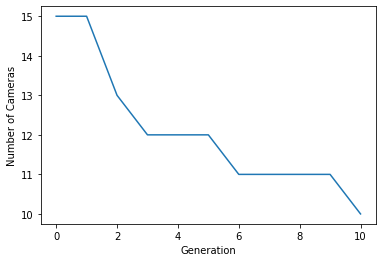

In [64]:
geneticAlgorithmPlot(population=Room, popSize=1000, eliteSize=20, mutationRate=0.01, generations=10)